Created some code to make the mnist-data into a segmentation problem. This was done by setting an semi-arbitrary threshold for the pixel intensity that we want to classify as belonging to the handwritten digit or not.

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

# Define number of classes
num_classes = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.array(x_train)
x_test = np.array(x_test)

# Threshold is what intensity value we use to label pixel as beloning to letter or not
threshold = 80
# The segmented data is now the ground truth instead of just the label
seg_train_data = np.zeros(x_train.shape)
seg_test_data = np.zeros(x_test.shape)
n_train = x_train.shape[0]
n_test = x_test.shape[0]

for i in range(n_train):
    if i % 10000 == 0:
        print(i)
    # Get indices of where number is larger than threshold
    ind = np.where(x_train[i] > threshold)
    # Make a empty matrix to fill with the label value at the index locations
    temp = np.zeros(x_train[i].shape)
    # since we do one hot encoding we don't need the line below
    #label = y_train[i]
    #temp[ind] = label 
    temp[ind] = 1
    seg_train_data[i] = temp

# Do the same for the test data
for i in range(n_test):
    if i % 10000 == 0:
        print(i)
    ind = np.where(x_test[i] > threshold)
    temp = np.zeros(x_test[i].shape)
    temp[ind] = 1
    seg_test_data[i] = temp


Using TensorFlow backend.


0
10000
20000
30000
40000
50000
0


Show that segmentation worked

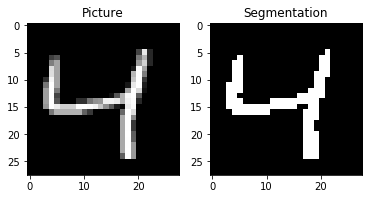

In [2]:
i = 2
plt.subplot(121)
plt.imshow(x_train[i], cmap='gray')
plt.title('Picture')
plt.subplot(122)
plt.imshow(seg_train_data[i], cmap='gray')
plt.title('Segmentation')
plt.show()

In [3]:
# Make one hot encoding
one_hot_enc_seg_train = np.zeros([n_train, 28, 28, num_classes])
one_hot_enc_seg_test = np.zeros([n_test, 28, 28, num_classes])

# The shape of the ouput tensor of UNet
pic_shape = list(x_train[i].shape) + [num_classes]

for i in range(n_train):
    if i % 10000 == 0:
        print(i)
    # Make a empty matrix to fill with the label value at the index locations
    temp = np.zeros(pic_shape)
    label = y_train[i]
    # labels=[1,...,10] but index=[0,...,9] therefore the -1
    temp[:,:,(label-1)] = seg_train_data[i]
    one_hot_enc_seg_train[i, :, :, :] = temp

for i in range(n_test):
    if i % 10000 == 0:
        print(i)
    # Make a empty matrix to fill with the label value at the index locations
    temp = np.zeros(pic_shape)
    label = y_test[i]
    temp[:,:,(label-1)] = seg_test_data[i]
    one_hot_enc_seg_test[i, :, :, :] = temp

0
10000
20000
30000
40000
50000
0


(28, 28, 10)


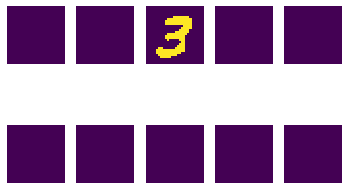

In [4]:
# Visualise one hot encoding
for i in range(num_classes):
    # Really hacky solution with i>4 being false aka 0 first then being true aka 1 and using that as index
    plt.subplot2grid((2,5), (i>4, i%5))
    plt.imshow(one_hot_enc_seg_train[7, :, :, i])
    plt.axis("off")

print(one_hot_enc_seg_train[7, :, :, :].shape)

The artificially segmented mnist-data will serve as data to get UNet to work.

In [5]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet_mnist(pretrained_weights = None, input_size = (28, 28, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    
    up4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop3))
    merge4 = concatenate([drop2, up4], axis = 3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    
    up5 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv1, up5], axis = 3)
    conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
    conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    
    conv6 = Conv2D(num_classes, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    model = Model(input = inputs, output = conv6)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

my_model = unet_mnist()
my_model.summary()



W0917 19:07:08.498348 4674860480 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 19:07:08.523654 4674860480 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 19:07:08.527161 4674860480 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0917 19:07:08.559196 4674860480 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_p

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [6]:
# Train model
x_train = x_train.reshape((60000, 28, 28, 1))
my_model.fit(x=x_train, y=one_hot_enc_seg_train, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)


Epoch 1/1
60000/60000 [==============================] - 795s 13ms/step - loss: 0.1800 - acc: 0.9798


In [159]:
# Make a prediction from the test set
x = x_test[0].reshape((1,28,28,1))
yhat = my_model.predict(x)

[[[[0.16049981 0.12203228 0.06114971 ... 0.1281078  0.0372082
    0.02126056]
   [0.1407519  0.10862114 0.06807805 ... 0.13003948 0.06439431
    0.04098335]
   [0.15310636 0.12810023 0.06870762 ... 0.13466834 0.04577941
    0.02593979]
   ...
   [0.12798606 0.08670918 0.0586959  ... 0.11098132 0.07868593
    0.04561461]
   [0.10003818 0.10140906 0.0994684  ... 0.1006792  0.09891256
    0.10011367]
   [0.09242448 0.16078353 0.11251429 ... 0.094742   0.06361426
    0.10496533]]

  [[0.08956975 0.08534926 0.090573   ... 0.13650742 0.12265358
    0.10320051]
   [0.10003818 0.10140906 0.0994684  ... 0.1006792  0.09891256
    0.10011367]
   [0.10003818 0.10140906 0.0994684  ... 0.1006792  0.09891256
    0.10011367]
   ...
   [0.04415923 0.12751362 0.05818722 ... 0.07635512 0.22444808
    0.01848958]
   [0.10292409 0.10391297 0.10560188 ... 0.09362184 0.09430819
    0.09842195]
   [0.09963188 0.10192695 0.0993089  ... 0.10074648 0.09993282
    0.09894942]]

  [[0.09671113 0.10584649 0.0929843

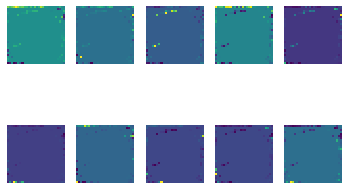

In [158]:
# Visualise one hot encoding
for i in range(num_classes):
    # Really hacky solution with i>4 being false aka 0 first then being true aka 1 and using that as index
    plt.subplot2grid((2,5), (i>4, i%5))
    plt.imshow(yhat[0, :, :, i])
    plt.axis("off")

#This does not seem like 95% accuracy as the training said